# **Amazon review classification**

This notebook is a personal training to train on text preprocessing, use of word embedding and pytorch neural networks

## **Get the required data, packages and basic utility functions**

In [ ]:
#!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
#!unzip glove.6B.zip

--2021-08-23 09:29:53--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2021-08-23 09:29:53--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2021-08-23 09:29:53--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [1]:
import pandas as pd
import json
import gzip
import unicodedata
import string
import torch
import torchvision
import numpy as np
import gensim
import tensorflow as tf
import sys
import pickle
import nltk

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path,imin,imax):
    i = 0
    df = {}
    for d in parse(path):
        if i<imin and i!=0:
            i+=1
            continue
        if i>=imax:
            break
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index',dtype="string")

def getcleanDF():
    return pd.read_csv("drive/MyDrive/Colab Notebooks/dataset_clean.csv",usecols=[1,2]).dropna()

def getcleanDF_lemma():
    return pd.read_csv("drive/MyDrive/Colab Notebooks/dataset_clean_lemma.csv",usecols=[1,2]).dropna()

def clean_txt(txt):
    txt=unicodedata.normalize("NFD",txt.lower())
    result=""
    for i in range(len(txt)):
        char=txt[i]
        if char=="." and txt[min(i+1,len(txt)-1)]!=" ":
            result=result+". "
        elif unicodedata.category(char) != 'Mn':
            result=result+char
    return result

def clean_punctuation(text):
    try:
        return text.replace("."," .").replace(",", " ,").replace("!"," !").replace("?", " ?").replace("\"","").replace("(","").replace(")","").replace("\'","")
    except:
        print(text)
        assert False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Clean the dataset: load it and clean the text, drop the useless rows/columns. (Already been run so no need to run it again)**

In [ ]:
df=getDF('drive/MyDrive/Colab Notebooks/reviews_Movies_and_TV_5.json.gz',0,10000000)[["overall","reviewText"]]
df["reviewText"]=df["reviewText"].apply(clean_txt)
df["reviewText"]=df["reviewText"].apply(clean_punctuation)
df.to_csv("drive/MyDrive/Colab Notebooks/dataset_clean.csv")
del df

In [ ]:
# Load the clean dataset
df_clean=getcleanDF().sample(frac=1).reset_index(drop=True) # Loads the dataset and shuffles it

#Split the test and train dataframe to have 50,000 training elements (arbitrary to make the evalutation not too long)
test_df=df_clean.iloc[:50000]
df_clean=df_clean.iloc[50000:]

In [ ]:
print(df_clean.columns)

Index(['overall', 'reviewText'], dtype='object')


## **Create the embedding layer and initialize it with the pretrained Glove6B d=100**

Embedding matrix: $\begin{pmatrix} f_{1,1}&\dots& f_{1,d}\\
\vdots& &\vdots\\
f_{n,1}& \dots & f_{n,d}
\end{pmatrix}
$ with $n=$ vocabulary size

([code stolen here](https://androidkt.com/pre-train-word-embedding-in-pytorch/))

In [ ]:
glove = pd.read_csv('drive/MyDrive/Colab Notebooks/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print("Vocabulary size=",len(glove_embedding))

Vocabulary size= 399999


In [ ]:
load=True #Use the previous tokenizer (adviced for speedup if nothing was changed before, otherwise set to false and run the cell below)
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))
  frozen_index=[]
  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
      frozen_index.append(index)
  return embedding_matrix,frozen_index
 
text=df_clean["reviewText"]
 
if not load:
    tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
    tokenizer.fit_on_texts(text)
else:
    # loading
    with open('drive/MyDrive/Colab Notebooks/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
 
text_token_test=tokenizer.texts_to_sequences(test_df["reviewText"])
text_token=tokenizer.texts_to_sequences(text)
print(text_token[0])

embedding_matrix,frozen_index=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=100)
frozen_index=np.array(frozen_index)

[31, 5083, 4, 88, 1, 1688, 4, 1664, 453, 1450, 25, 153, 7, 1, 444, 935, 2, 578, 13, 25, 1295, 6, 7341, 33, 3, 729, 80, 3, 676, 2, 31, 642, 4, 6927, 29074, 731, 6133, 5, 5859, 3, 3652, 8, 57, 141, 11, 8, 15, 22, 983, 14, 1, 626, 2017, 5, 138, 9, 17, 35, 8, 204, 2029, 785, 1, 17, 109, 1, 248, 1193, 8, 15, 4474, 14, 1, 764, 4, 1, 21, 14, 29, 4907, 4, 453, 12232, 7, 1, 11181, 4, 56, 99, 138, 9, 17, 12, 227, 635, 415, 10, 6, 3, 181, 25, 8, 57, 141, 11, 1, 17, 39, 3, 52, 1251, 631, 2, 8, 114, 65, 164, 62714, 68, 3, 872, 56, 14, 10, 8, 113, 8, 5577, 3, 117, 1729, 138, 12277, 32, 317, 330, 5, 5224, 1, 4791, 7, 9, 75, 8, 60, 24, 82, 32, 1, 810, 6164, 13356, 1839, 72, 212, 3, 194, 4, 2196, 44, 5430, 7, 29, 764, 4, 10571, 117704, 8, 57, 141, 11, 8, 15, 1424, 32, 1, 1907, 585, 11, 2434, 5620, 2, 334, 245, 485, 1, 17, 1, 2829, 15, 35, 905, 32, 193, 11, 8, 165, 2544, 36, 34, 69, 337, 1, 134, 1177, 245, 8, 214, 50, 4, 1, 429, 758, 1, 17, 245, 117, 75, 334, 2, 69, 46, 350, 32, 193, 5, 1, 3468, 11, 50,

In [ ]:
# saving
with open('drive/MyDrive/Colab Notebooks/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(embedding_matrix.shape)
vocab_size=embedding_matrix.shape[0]
vector_size=embedding_matrix.shape[1]
 
embedding=torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
embedding.weight=torch.nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))

(944803, 100)


Embedding(944803, 100)

In [ ]:
# Pad the text_token so it can fit in the embedding layer (not needed for now)
# Perhaps 150 will give better results because long sentences are annoying to deal with
text_token_padded=tf.keras.preprocessing.sequence.pad_sequences(text_token, maxlen=150)
text_token_padded_test=tf.keras.preprocessing.sequence.pad_sequences(text_token_test,maxlen=150)

We now have a working embedding layer provided the sentences are paded and tokenized with the keras preprocessing module.

## **Create a Dataset that fetches one sentence and embeds it through gpu**

In [ ]:
print(df_clean)

         overall                                         reviewText
50000        3.0  an exploration of how the actions of individua...
50001        5.0  this little film shows that great movies can b...
50002        5.0  saw the first installment of this series and k...
50003        3.0  a fun disney film made all the better because ...
50004        2.0  i like to think i have a solid sense of humor ...
...          ...                                                ...
1697466      3.0  the difference between most animated features ...
1697467      5.0  to laugh ! ! !you will laugh thru the whole mo...
1697468      4.0  after the death of her mother , 12-year-old ni...
1697469      4.0  yo , wuz up ? i missed taping this show on my ...
1697470      5.0  i absolutely adore this production . jennifer ...

[1647471 rows x 2 columns]


In [ ]:
class ProcessedDataset(torch.utils.data.Dataset):
    def __init__(self,text_token,ratings,embeddingLayer,device):
        self.text_token=text_token
        self.embeddingLayer=embeddingLayer
        self.ratings=ratings
        self.device=device
    
    def __len__(self):
        return len(self.text_token)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        token_sentence=torch.tensor(self.text_token[idx],dtype=torch.long)
        token_sentence=token_sentence.to(self.device)
        sentence=self.embeddingLayer(token_sentence)
        rating=self.ratings.iloc[idx]
        return sentence,rating

dataset=ProcessedDataset(text_token,df_clean["overall"],embedding,device)
print(dataset[0])

(tensor([[-0.4214, -0.1880,  0.4624,  ..., -0.5652,  0.7256, -0.1591],
        [ 0.0565,  0.1737, -0.0178,  ..., -0.1445, -0.4455,  0.0312],
        [-0.1529, -0.2428,  0.8984,  ..., -0.5910,  1.0039,  0.2066],
        ...,
        [ 0.1120,  0.6086,  0.3556,  ...,  0.1639,  0.2508, -0.5983],
        [ 0.2877,  0.4999,  0.7132,  ..., -0.2713,  0.2402,  0.1282],
        [ 0.3825,  0.1482,  0.6060,  ...,  0.0589,  0.0911,  0.4728]],
       device='cuda:0', grad_fn=<EmbeddingBackward>), 3.0)


In [ ]:
class NetworkBatched(torch.nn.Module):
    def __init__(self,embedding_dim ,hidden_dim, output_dim, layers_lstm, embedding_layer):
        super(NetworkBatched,self).__init__()
        self.lstm=torch.nn.LSTM(embedding_dim,hidden_dim,num_layers=layers_lstm,batch_first=True)
        self.linear1=torch.nn.Linear(hidden_dim, 128)
        self.relu1=torch.nn.ReLU()
        self.linear2=torch.nn.Linear(128, 128)
        self.relu2=torch.nn.ReLU()
        self.linear3=torch.nn.Linear(128, 1)
        self.embedding_layer=embedding_layer
    
    def forward(self, sentence):
        embedded_sentence=self.embedding_layer(sentence)
        lstm_out,_ = self.lstm(embedded_sentence) #.view(batch_size, len(sentence), -1)
        #(batch_size, sequence_length, hidden_dim)
        lstm_out_avg=torch.mean(lstm_out,dim=1)
        output=self.relu1(self.linear1(lstm_out_avg))
        output=self.relu2(self.linear2(output))
        output=self.linear3(output)
        return output

network=NetworkBatched(100,128,1,3,embedding)
try:
    network.to(device)
    print(f"Network successfuly sent to the device: {device}")
except:
    print("Network couldn't be sent to the computing device")
loss_function=torch.nn.MSELoss()
optimizer=torch.optim.SGD(network.parameters(), lr=0.01)

In [ ]:
# Pretrained with batch

network.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/model_slighttrain_batched.pt'))

<All keys matched successfully>

In [ ]:
#With batch
batch_size=32
for g in optimizer.param_groups:
    g['lr'] = 0.003

for epoch in range(10):
    for g in optimizer.param_groups:
        g['lr'] = g['lr']*0.9
    print(f"---Epoch {epoch}---")
    sum_loss=0
    for i in range(int(len(dataset)/batch_size)):
        indices=torch.LongTensor(batch_size).random_(0,len(dataset)-1) #indices of our minibatch chosen randomly
        sentence,star=text_token_padded[indices],df_clean["overall"].iloc[indices]
        sentence=torch.LongTensor(sentence).to(device)
        #sentence.requires_grad_()
        network.zero_grad()
        star_pred=torch.squeeze(network(sentence))
        star=torch.tensor(np.array(star),dtype=torch.float).to(device)
        loss = loss_function(star_pred,star)
        loss.backward()
        network.embedding_layer.weight.grad[frozen_index,:]=0
        optimizer.step()
        sum_loss+=loss.item()
        #sys.stdout.write("\r"+str(sum_loss/(i+1)))
        #sys.stdout.flush()
        if i%1000==999:
            print("loss: ",sum_loss/(i%1000+1))
            sum_loss=0


In [ ]:
torch.save(network.state_dict(), 'drive/MyDrive/Colab Notebooks/model_slighttrain_batched.pt')

Let's test on a random bad review (under represented)

In [ ]:
def sentence_pred(x):
    x=clean_punctuation(clean_txt(x))
    x_token=tokenizer.texts_to_sequences([x])[0]
    x_token=torch.tensor(x_token,dtype=torch.long)
    x_token=x_token.to(device)
    embedded_sentence=embedding(x_token)
    print(network(embedµded_sentence).item())

def sentence_pred_batch(x,verbose=1):
    x=clean_punctuation(clean_txt(x))
    x_token=tokenizer.texts_to_sequences([x])
    x_token=torch.tensor(x_token,dtype=torch.long)
    x_token=x_token.to(device)
    #embedded_sentence=embedding(x_token)
    pred=network(x_token).item()
    if verbose:
        print(pred)
    return pred

In [ ]:
sentence_pred_batch("This was bad.")

-0.44193339347839355


-0.44193339347839355

In [ ]:
index=np.random.choice(df_clean[df_clean["overall"]<=2.]["overall"].index)
print("index: ",index)
print(df_clean["overall"].loc[index])
print(df_clean["reviewText"].loc[index])
#sentence=torch.LongTensor([text_token_padded[index]]).to(device)
#print(network(sentence))
_=sentence_pred_batch(df_clean["reviewText"].loc[index])

index:  574591
1.0
wow .  .  .  .  .  .  .  . this was bad . i think i laughed maybe twice tops . this was not entertaining at all mainly because her humour is strange , pointless and disturbing . nanas funeral , enough saidi enjoy comedians like dane cook , chris rock , margaret cho , russel peters , george carlin , mitch hedberg , seinfeld and more . so , as you can see i have a pretty wide variety of comedic tastes and i dont mind racial humour when it is done fairly meaning no race is exempt like russel peters . i think the most important thing about a comedian is thier ability to make you see/feel/understand what they are saying . but sarah silverman cant do that at all . be warned , you have to already be like her going in or else you wont like this at all .  read some of the other reviews before watching this i still dont know even vaguely what her point is . waste of time . 
1.3107630014419556


In [ ]:
def evaluate_model(test_df):
    batch_size=256
    confusion_matrix=np.zeros((5,5))
    ind=0
    while True:
        sentences=torch.LongTensor(text_token_padded_test[ind:min(ind+batch_size,len(text_token_padded_test))]).to(device)
        star_pred=network(sentences)
        for i in range(len(star_pred)):
            confusion_matrix[max(min(round(star_pred[i].item())-1,4),0),int(test_df["overall"].iloc[ind+i]-1)]+=1
        ind=ind+batch_size
        if ind>len(text_token_padded_test):
            break
    return confusion_matrix

In [ ]:
confusion_matrix=evaluate_model(test_df)

In [ ]:
print(confusion_matrix/np.sum(confusion_matrix))

[[3.0000e-02 8.4600e-03 1.4400e-03 3.0000e-04 2.6000e-04]
 [2.1100e-02 2.7660e-02 1.8980e-02 4.0600e-03 2.9000e-03]
 [6.4600e-03 1.4260e-02 4.1800e-02 1.6560e-02 9.3000e-03]
 [3.7400e-03 6.9200e-03 4.6340e-02 1.0582e-01 8.1200e-02]
 [9.0000e-04 1.2200e-03 1.1620e-02 9.5700e-02 4.4300e-01]]


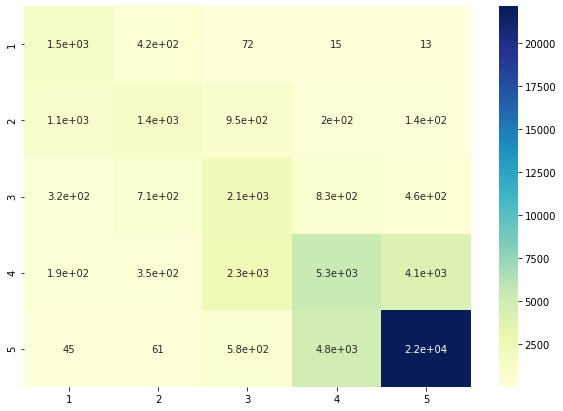

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(1,6)],
                  columns = [i for i in range(1,6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [ ]:
accuracy=sum([confusion_matrix[i,i] for i in range(len(confusion_matrix))])/np.sum(confusion_matrix)
print("global accuracy: ",accuracy)
low_accuracy=np.sum(confusion_matrix[:3,:3])/np.sum(confusion_matrix[:,:3])
high_accuracy=np.sum(confusion_matrix[3:,3:])/np.sum(confusion_matrix[:,3:])
print("low accuracy (<4): ", low_accuracy)
print("high accuracy (>=4): ", high_accuracy)
high_low_accuracy=(np.sum(confusion_matrix[:3,:3])+np.sum(confusion_matrix[3:,3:]))/np.sum(confusion_matrix)
print("high/low accuracy: ", high_low_accuracy)

global accuracy:  0.64828
low accuracy (<4):  0.7063511830635119
high accuracy (>=4):  0.9560268739296536
high/low accuracy:  0.89588


## Using lemmatizer from NLTK

In [3]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

class CustomLemmatizer:
    def __init__(self,lemmatizer):
        self.lemmatizer=lemmatizer
    
    def __call__(self, sentence):
        word_list=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        return ' '.join([x for x in word_list if x not in string.punctuation])

lemmatizer = WordNetLemmatizer()
customLemmatizer=CustomLemmatizer(lemmatizer)

# Testing our custom lemmatizer
customLemmatizer("The bats were hanging out,      chilling.    by the very relaxing sea!")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'The bat be hang out chill by the very relax sea'

In [ ]:
# Clean the dataset AND lemmatize it then save to a new csv file **CARE THIS CELL TAKES A WHILE TO RUN (more than 3h idk exactly)**

df=getcleanDF().sample(frac=1).reset_index(drop=True)
df["reviewText"]=df["reviewText"].apply(CustomLemmatizer(WordNetLemmatizer()))
df.to_csv("drive/MyDrive/Colab Notebooks/dataset_clean_lemma.csv")
del df

In [4]:
# Load the clean dataset
df_clean=getcleanDF_lemma().sample(frac=1).reset_index(drop=True) # Loads the dataset and shuffles it

#Split the test and train dataframe to have 50,000 training elements (arbitrary to make the evalutation not too long)
test_df=df_clean.iloc[:50000]
df_clean=df_clean.iloc[50000:]

In [5]:
glove = pd.read_csv('drive/MyDrive/Colab Notebooks/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print("Vocabulary size=",len(glove_embedding))

Vocabulary size= 399999


In [6]:
load=True #Use the previous tokenizer with lemma (advised for speedup if nothing was changed before, otherwise set to false and run the cell below)
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))
  frozen_index=[]
  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
      frozen_index.append(index)
  return embedding_matrix,frozen_index
 
text=df_clean["reviewText"]
 
if not load:
    tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
    tokenizer.fit_on_texts(text)
else:
    # loading
    with open('drive/MyDrive/Colab Notebooks/tokenizer_lemma.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
 
text_token_test=tokenizer.texts_to_sequences(test_df["reviewText"])
text_token=tokenizer.texts_to_sequences(text)
print(text_token[0])

embedding_matrix,frozen_index=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=100)
frozen_index=np.array(frozen_index)

[1, 53, 1, 116, 394, 809, 4, 587, 6, 672, 564, 34, 10, 3, 194, 12, 856, 66, 100, 209, 19, 61, 83, 263, 15, 3, 265, 3611, 14, 120, 150, 94, 70, 474, 52, 19, 12, 2, 154, 57, 10, 57, 6266]


In [ ]:
# saving
with open('drive/MyDrive/Colab Notebooks/tokenizer_lemma.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
print("shape of embedding matrix: ",embedding_matrix.shape)
vocab_size=embedding_matrix.shape[0]
vector_size=embedding_matrix.shape[1]
 
embedding=torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
embedding.weight=torch.nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))

shape of embedding matrix:  (922287, 100)


In [8]:
# Padding for batch purpose (considerably speeds up the training speed allowing matrix computation)
text_token_padded=tf.keras.preprocessing.sequence.pad_sequences(text_token, maxlen=150)
text_token_padded_test=tf.keras.preprocessing.sequence.pad_sequences(text_token_test,maxlen=150)

In [34]:
class NetworkBatched(torch.nn.Module):
    def __init__(self,embedding_dim ,hidden_dim, output_dim, layers_lstm, embedding_layer):
        super(NetworkBatched,self).__init__()
        self.lstm=torch.nn.LSTM(embedding_dim,hidden_dim,num_layers=layers_lstm,batch_first=True)
        self.linear1=torch.nn.Linear(hidden_dim, 256)
        self.relu1=torch.nn.ReLU()
        self.linear2=torch.nn.Linear(256, 256)
        self.relu2=torch.nn.ReLU()
        self.linear3=torch.nn.Linear(256, 128)
        self.relu3=torch.nn.ReLU()
        self.linear4=torch.nn.Linear(128, 1)
        self.embedding_layer=embedding_layer
    
    def forward(self, sentence):
        embedded_sentence=self.embedding_layer(sentence)
        lstm_out,_ = self.lstm(embedded_sentence) #.view(batch_size, len(sentence), -1)
        #(batch_size, sequence_length, hidden_dim)
        lstm_out_avg=torch.mean(lstm_out,dim=1)
        output=self.relu1(self.linear1(lstm_out_avg))
        output=self.relu2(self.linear2(output))
        output=self.relu3(self.linear3(output))
        output=self.linear4(output)
        return output

network=NetworkBatched(100,256,1,5,embedding)
try:
    network.to(device)
    print(f"Network successfuly sent to the device: {device}")
except:
    print("Network couldn't be sent to the computing device")
loss_function=torch.nn.MSELoss()
optimizer=torch.optim.SGD(network.parameters(), lr=0.01)

Network successfuly sent to the device: cuda:0


In [ ]:
# Pretrained with batch and lemma

network.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/model_slighttrain_batchedbig_lemma.pt'))

In [44]:
#With batch
batch_size=100
for g in optimizer.param_groups:
    g['lr'] = 0.05

for epoch in range(20):
    for g in optimizer.param_groups:
        g['lr'] = g['lr']*0.9
    print(f"---Epoch {epoch}---")
    print("\n")
    sum_loss=0
    for i in range(int(len(text_token_padded)/batch_size)):
        indices=torch.LongTensor(batch_size).random_(0,len(text_token_padded)-1) #indices of our minibatch chosen randomly
        sentence,star=text_token_padded[indices],df_clean["overall"].iloc[indices]
        sentence=torch.LongTensor(sentence).to(device)
        #sentence.requires_grad_()
        network.zero_grad()
        star_pred=torch.squeeze(network(sentence))
        star=torch.tensor(np.array(star),dtype=torch.float).to(device)
        loss = loss_function(star_pred,star)
        loss.backward()
        network.embedding_layer.weight.grad[frozen_index,:]=0
        optimizer.step()
        sum_loss+=loss.item()
        #sys.stdout.write("\r"+str(sum_loss/(i+1)))
        #sys.stdout.flush()
        if i%250==249:
            sys.stdout.write(f"\r Average loss at step {str(i+1)}/{str(int(len(text_token_padded)/batch_size))}: "+str(sum_loss/(i+1)))
            sys.stdout.flush()
    sys.stdout.write("\r Average loss: "+str(sum_loss/(i+1)))
    sys.stdout.write("")
    sys.stdout.flush()

---Epoch 0---


 Average loss: 0.6415919407901869---Epoch 1---


 Average loss: 0.6015428070698503---Epoch 2---


 Average loss: 0.5782809142514935---Epoch 3---


 Average loss: 0.5647885944774331---Epoch 4---


 Average loss: 0.549195865049544---Epoch 5---


 Average loss at step 2500/16474: 0.5425459316015243

KeyboardInterrupt: ignored

In [45]:
torch.save(network.state_dict(), 'drive/MyDrive/Colab Notebooks/model_slighttrain_batchedbig_lemma.pt')

In [37]:
def sentence_pred(x):
    x=clean_punctuation(clean_txt(x))
    x_token=tokenizer.texts_to_sequences([x])[0]
    x_token=torch.tensor(x_token,dtype=torch.long)
    x_token=x_token.to(device)
    embedded_sentence=embedding(x_token)
    print(network(embedµded_sentence).item())

def sentence_pred_batch(x,verbose=1):
    x=customLemmatizer(clean_txt(clean_txt(x)))
    x_token=tokenizer.texts_to_sequences([x])
    x_token=torch.tensor(x_token,dtype=torch.long)
    x_token=x_token.to(device)
    #embedded_sentence=embedding(x_token)
    pred=network(x_token).item()
    if verbose:
        print(pred)
    return pred

In [52]:
sentence_pred_batch("Although I thought it would be funny, I was a bit disappointed by the poor performance of the actors and the gross jokes.")

2.520033359527588


2.520033359527588

In [47]:
def evaluate_model(test_df):
    batch_size=512
    confusion_matrix=np.zeros((5,5))
    ind=0
    while True:
        sentences=torch.LongTensor(text_token_padded_test[ind:min(ind+batch_size,len(text_token_padded_test))]).to(device)
        star_pred=network(sentences)
        for i in range(len(star_pred)):
            confusion_matrix[max(min(round(star_pred[i].item())-1,4),0),int(test_df["overall"].iloc[ind+i]-1)]+=1
        ind=ind+batch_size
        if ind>len(text_token_padded_test):
            break
    return confusion_matrix

confusion_matrix=evaluate_model(test_df)

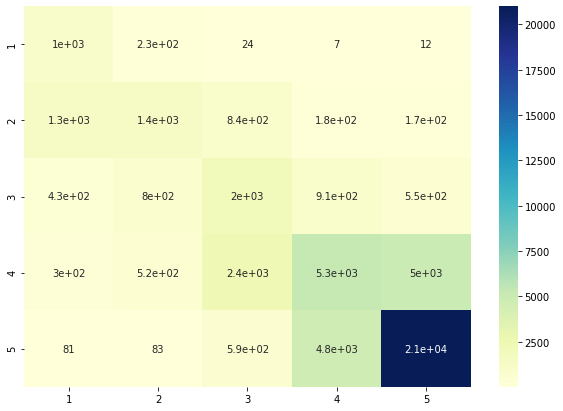

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(1,6)],
                  columns = [i for i in range(1,6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [49]:
accuracy=sum([confusion_matrix[i,i] for i in range(len(confusion_matrix))])/np.sum(confusion_matrix)
print("global accuracy: ",accuracy)
low_accuracy=np.sum(confusion_matrix[:3,:3])/np.sum(confusion_matrix[:,:3])
high_accuracy=np.sum(confusion_matrix[3:,3:])/np.sum(confusion_matrix[:,3:])
print("low accuracy (<4): ", low_accuracy)
print("high accuracy (>=4): ", high_accuracy)
high_low_accuracy=(np.sum(confusion_matrix[:3,:3])+np.sum(confusion_matrix[3:,3:]))/np.sum(confusion_matrix)
print("high/low accuracy: ", high_low_accuracy)

global accuracy:  0.614
low accuracy (<4):  0.6667772983737139
high accuracy (>=4):  0.9518815220828503
high/low accuracy:  0.88316
